In [1]:
import os
import sys
import subprocess
import datetime as dt
import itertools
import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster, wait
import dask.array as da
import matplotlib.pyplot as plt
import cmocean
from MHW_daily_calcs import *

In [2]:
climyrs=[1993,2023]
qtile=0.90
smoothmethod='tri'
window=11

smoothedClim=True
smoothedTrend=True

In [3]:
cluster = LocalCluster(n_workers=6,threads_per_worker=1,dashboard_address='localhost:54924')
client = Client(cluster)

In [28]:
delt=5
lmax=215

In [29]:
def leadbounds(l0,lmax,delt):
    i0=min(max(l0-delt,0),lmax-(2*delt+1))
    return i0, i0+2*delt+1
[el for el in range(*leadbounds(5,215,))]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [4]:
# version 1: 10 day windows in lead time
jj=60
l0=11
delt=5
def getind(i0):
    if i0>=1 and i0<=10:
        return [i0-1,i0,i0+1]
    elif i0==0:
        return [11,0,1]
    elif i0==11:
        return [10,11,0]
def leadbounds(l0,lmax,delt):
    i0=min(max(l0-delt,0),lmax-(2*delt+1))
    return i0, i0+2*delt+1
flist=[fnameCanESMAnomDetrByLead(workdir, climyrs[0], climyrs[-1], ilead, jj,smoothClim=True,smoothTrend=True,meth=smoothmethod,win=window) \
        for ilead in range(*leadbounds(l0,215,delt))]
ff=xr.open_mfdataset(flist,combine='nested',concat_dim=['leadtime'],parallel=True,decode_times=False)
fc=ff.sst_an.coarsen(reftime=12,boundary='pad').construct(reftime=('year','month'))
sh=fc.shape
ql1=np.nan*np.ones((12,sh[-2],sh[-1]))
ql2=np.nan*np.ones((12,sh[-2],sh[-1]))
for ii in range(0,12):
    pool1=fc.isel(month=ii).values.reshape((sh[0]*sh[1]*sh[3],sh[4],sh[5]))
    ql1[ii,...]=np.nanquantile(pool,0.9,axis=0)
    pool2=fc.sel(month=getind(ii)).values.reshape((sh[0]*sh[1]*3*sh[3],sh[4],sh[5]))
    ql2[ii,...]=np.nanquantile(pool,0.9,axis=0)

In [15]:
# version 2: 10 day windows in lead time AND +/1 1 month windows
for ii in range(0,12):
    pool2=fc.sel(month=getind(ii)).values.reshape((sh[0]*sh[1]*3*sh[3],sh[4],sh[5]))
    ql2[ii,...]=np.nanquantile(pool,0.9,axis=0)

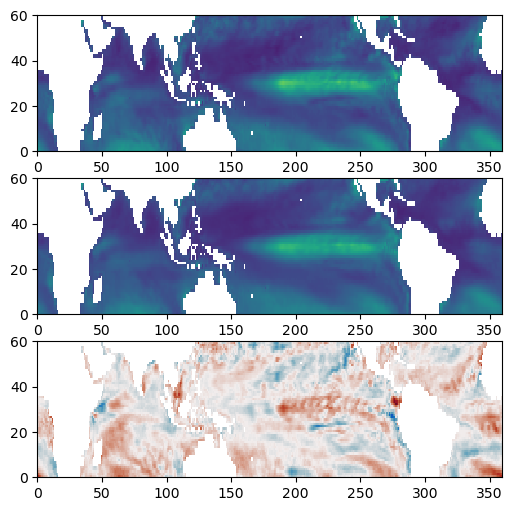

In [21]:
fig,ax=plt.subplots(3,1,figsize=(6,6))
ax[0].pcolormesh(ql[0,:,:],vmin=0,vmax=3)
ax[1].pcolormesh(ql2[0,:,:],vmin=0,vmax=3)
ax[2].pcolormesh(ql[0,:,:]-ql2[0,:,:],vmin=-.5,vmax=.5,cmap=cmocean.cm.balance)